In [1]:
# Cell 0: Setup
import os, json, math, time, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


In [2]:
# Cell 1: Constraints & grids

# --- Temperatures (Celsius) ---
T_ENV_C = 700.0     # installation environment
T_NA_IN_C = 550.0   # sodium operating temperature
T_NA_BOIL_C = 883.0 # sodium boiling at 1 atm

# --- Geometry: double-walled pipe (your values) ---
Di_m = 15.8e-3
ti_m = 2.5e-3
Do1_m = 20.8e-3

Di2_m = 24.8e-3
to_m  = 2.0e-3
Do2_m = 28.8e-3

ANNULUS_GAS = "Ar"     # inert gas set to Argon
PINHOLE_D_m = 0.5e-3

P_ANN_BASE_MPA_RANGE = (0.10, 0.30)  # MPa
P_NA_IN_MPA = 1.0
M_DOT_NA_KG_S_RANGE = (0.5, 1.2)

# --- RDTS spatial grid (1m bins) ---
PIPE_LEN_M = 100
DX = 1
NX = PIPE_LEN_M // DX + 1
X = np.arange(NX) * DX

# --- Time grid (fast) ---
DT = 1.0
T_TOTAL = 600  # 10 minutes
NT = int(T_TOTAL / DT)
T = np.arange(NT) * DT

# --- Windowing (real-time style) ---
W_SECONDS = 120
W = int(W_SECONDS / DT)
STRIDE = 10

print("NX:", NX, "NT:", NT, "Window:", W, "Stride:", STRIDE, "Gas:", ANNULUS_GAS)

NX: 101 NT: 600 Window: 120 Stride: 10 Gas: Ar


In [3]:
# Cell 2: Utilities

def gaussian_kernel_1d(sigma_bins: float, radius: int = None):
    if sigma_bins <= 0:
        return np.array([1.0], dtype=np.float32)
    if radius is None:
        radius = int(max(1, math.ceil(3 * sigma_bins)))
    xs = np.arange(-radius, radius + 1)
    k = np.exp(-(xs**2) / (2 * sigma_bins**2))
    k = k / k.sum()
    return k.astype(np.float32)

def conv1d_same(signal_1d: np.ndarray, kernel_1d: np.ndarray):
    return np.convolve(signal_1d, kernel_1d, mode="same")

def moving_average_1d(arr_1d: np.ndarray, k: int):
    if k <= 1:
        return arr_1d
    kernel = np.ones(k, dtype=np.float32) / k
    return np.convolve(arr_1d, kernel, mode="same")

def soft_ramp(t_idx: np.ndarray, t0: int, tau: float):
    s = np.zeros_like(t_idx, dtype=np.float32)
    mask = t_idx >= t0
    s[mask] = 1.0 - np.exp(-(t_idx[mask] - t0) / max(tau, 1e-6))
    return s

def fft_band_power(x, fs=1.0, f_lo=0.15, f_hi=0.45):
    """
    With dt=1s -> Nyquist=0.5 Hz.
    We'll use 0.15~0.45 Hz as a "high-frequency" proxy band.
    """
    x = np.asarray(x, dtype=np.float32)
    x = x - float(np.mean(x))
    n = len(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    Xf = np.fft.rfft(x)
    psd = (np.abs(Xf)**2) / max(n, 1)
    mask = (freqs >= f_lo) & (freqs <= f_hi)
    return float(psd[mask].sum())

In [4]:
# Cell 3: Geometry helpers + gas constants (optional in this effective model)

def circle_area(d_m):
    return math.pi * (d_m**2) / 4.0

A_inner_flow = circle_area(Di_m)
A_annulus = circle_area(Di2_m) - circle_area(Do1_m)
V_annulus = A_annulus * PIPE_LEN_M

R_UNIV = 8.314462618
R_SPEC = {
    "He": R_UNIV / 0.004002602,
    "N2": R_UNIV / 0.0280134,
    "Ar": R_UNIV / 0.039948,
}

print("A_inner_flow:", A_inner_flow)
print("A_annulus:", A_annulus)
print("V_annulus:", V_annulus)
print("R_spec(Ar):", R_SPEC["Ar"])

A_inner_flow: 0.000196066797510539
A_annulus: 0.00014325662500369455
V_annulus: 0.014325662500369455
R_spec(Ar): 208.13213722839694


In [5]:
# Cell 4: Double-wall simulator with Ar annulus + temperature vibration proxy

def simulate_case_double_wall_tempvib(
    leak: bool,
    # axial thermal dynamics (effective)
    kappa_range=(0.03, 0.12),
    lam_range=(0.001, 0.008),

    # leak thermal anomaly
    A_T_range=(2.0, 10.0),
    sigma_bins_range=(0.8, 2.5),
    tau_T_range=(5.0, 25.0),

    # leak timing
    t0_range=(60, 360),
    dur_range=(60, 240),

    # annulus pressure rise (effective)
    p_rise_rate_range=(0.0008, 0.0040),  # MPa/s
    tau_P_range=(10.0, 60.0),

    # nuisance events
    drift_prob=0.35,
    local_event_prob=0.35,

    # RDTS measurement effects
    space_blur_bins_range=(0.8, 1.6),
    time_avg_k_range=(3, 7),
    noise_std_range=(0.15, 0.60),

    # temperature vibration (HF proxy) when leak
    temp_vib_amp_range=(0.3, 2.0),
    temp_vib_noise_std=0.05,
):
    # sample thermal params
    kappa = float(np.random.uniform(*kappa_range))
    lam = float(np.random.uniform(*lam_range))
    r = kappa * DT / (DX**2)
    if r > 0.45:
        kappa = 0.45
        r = kappa

    # baseline temperature in harsh environment (700C) influenced by sodium (550C)
    base_level = T_ENV_C - 0.15*(T_ENV_C - T_NA_IN_C)
    T_true = np.zeros((NT, NX), dtype=np.float32) + base_level

    # global drift
    drift_on = (np.random.rand() < drift_prob)
    drift_slope = float(np.random.uniform(-0.004, 0.004)) if drift_on else 0.0

    # nuisance local event (normal but confusing)
    local_event_on = (np.random.rand() < local_event_prob)
    if local_event_on:
        x_n = int(np.random.randint(0, NX))
        A_n = float(np.random.uniform(0.8, 3.5))
        sig_n = float(np.random.uniform(1.0, 3.5))
        t0_n = int(np.random.randint(30, 420))
        t1_n = int(min(NT-1, t0_n + np.random.randint(30, 180)))
        prof_n = np.exp(-((X - X[x_n])**2) / (2*(sig_n*DX)**2)).astype(np.float32)
        s_n = soft_ramp(np.arange(NT), t0_n, tau=float(np.random.uniform(3.0, 20.0)))
        s_n[np.arange(NT) > t1_n] = 0.0
    else:
        x_n, A_n, sig_n, t0_n, t1_n = None, 0.0, 0.0, None, None
        prof_n = np.zeros(NX, dtype=np.float32)
        s_n = np.zeros(NT, dtype=np.float32)

    # leak timing/location
    x0_bin = -1
    if leak:
        x0_bin = int(np.random.randint(0, NX))
        t0 = int(np.random.randint(*t0_range))
        dur = int(np.random.randint(*dur_range))
        t1 = int(min(NT-1, t0 + dur))
    else:
        t0, t1 = None, None

    # leak thermal anomaly
    if leak:
        A_T = float(np.random.uniform(*A_T_range))
        sig = float(np.random.uniform(*sigma_bins_range))
        tauT = float(np.random.uniform(*tau_T_range))
        prof_leak = np.exp(-((X - X[x0_bin])**2) / (2*(sig*DX)**2)).astype(np.float32)
        s_leak = soft_ramp(np.arange(NT), t0, tau=tauT)
        s_leak[np.arange(NT) > t1] = 0.0
    else:
        A_T, sig, tauT = 0.0, 0.0, 0.0
        prof_leak = np.zeros(NX, dtype=np.float32)
        s_leak = np.zeros(NT, dtype=np.float32)

    # annulus pressure baseline + rise
    P0 = float(np.random.uniform(*P_ANN_BASE_MPA_RANGE))
    P_ann = np.zeros(NT, dtype=np.float32) + P0
    if leak:
        rise_rate = float(np.random.uniform(*p_rise_rate_range))
        tauP = float(np.random.uniform(*tau_P_range))
        sP = soft_ramp(np.arange(NT), t0, tau=tauP)
        sP[np.arange(NT) > t1] = 0.0
        P_ann = (P0 + np.cumsum(rise_rate * sP)).astype(np.float32)
    else:
        rise_rate, tauP = 0.0, 0.0

    # temperature vibration signal (HF proxy), active only when leak
    temp_vib = np.zeros(NT, dtype=np.float32)
    if leak:
        tt = np.arange(NT) * DT
        freqs = np.random.uniform(0.15, 0.45, size=3)
        amps = np.random.uniform(*temp_vib_amp_range, size=3)
        hf = sum(a*np.sin(2*np.pi*f*tt) for a, f in zip(amps, freqs))
        hf = hf.astype(np.float32)
        active = (np.arange(NT) >= t0) & (np.arange(NT) <= t1)
        temp_vib[active] = hf[active]
    temp_vib += np.random.normal(0.0, temp_vib_noise_std, size=NT).astype(np.float32)

    # thermal sources
    Q_T = (A_T * s_leak)[:, None] * prof_leak[None, :] + (A_n * s_n)[:, None] * prof_n[None, :]

    # simulate 1D thermal field
    for n in range(NT - 1):
        Tn = T_true[n]
        lap = Tn[2:] - 2.0*Tn[1:-1] + Tn[:-2]
        drift_add = drift_slope * DT

        T_true[n+1, 1:-1] = (
            Tn[1:-1]
            + r * lap
            - lam * DT * (Tn[1:-1] - T_ENV_C)   # exchange to 700C env
            + DT * Q_T[n, 1:-1]
        ) + drift_add

        T_true[n+1, 0]  = T_true[n+1, 1]
        T_true[n+1, -1] = T_true[n+1, -2]

        # mild coupling: annulus pressure rise -> slight thermal offset
        T_true[n+1] += 0.05 * (P_ann[n+1] - P0)

        # inject local temperature vibration around leak location
        if leak:
            vib_prof = np.exp(-((X - X[x0_bin])**2) / (2*(1.0*DX)**2)).astype(np.float32)  # ~1m spread
            T_true[n+1] += temp_vib[n+1] * vib_prof

    # RDTS measurement effects: spatial blur + temporal averaging + noise
    space_blur_bins = float(np.random.uniform(*space_blur_bins_range))
    k_space = gaussian_kernel_1d(space_blur_bins)

    T_space = np.zeros_like(T_true)
    for n in range(NT):
        T_space[n] = conv1d_same(T_true[n], k_space)

    time_k = int(np.random.randint(time_avg_k_range[0], time_avg_k_range[1]+1))
    T_time = np.zeros_like(T_space)
    for i in range(NX):
        T_time[:, i] = moving_average_1d(T_space[:, i], time_k)

    noise_std = float(np.random.uniform(*noise_std_range))
    T_meas = T_time + np.random.normal(0.0, noise_std, size=T_time.shape).astype(np.float32)

    meta = {
        "leak": int(leak),
        "x0_bin": int(x0_bin),
        "t0": t0, "t1": t1,
        "kappa": kappa, "lambda": lam, "r": float(r),
        "A_T": A_T, "sigma_bins": sig, "tauT": tauT,
        "P0_MPa": P0, "rise_rate_MPa_s": rise_rate, "tauP": tauP,
        "drift_on": bool(drift_on), "drift_slope": drift_slope,
        "local_event_on": bool(local_event_on),
        "space_blur_bins": space_blur_bins,
        "time_avg_k": time_k,
        "noise_std": noise_std,
        "ANNULUS_GAS": ANNULUS_GAS,
    }

    return T_meas, P_ann, temp_vib, int(leak), int(x0_bin), meta

In [6]:
# Cell 5: Window labeling using true leak interval overlap

def window_overlap_ratio(win_start, win_end, leak_start, leak_end):
    """
    Ratio of overlap length / window length.
    Intervals are [start, end) in seconds (or indices with dt=1).
    """
    if leak_start is None or leak_end is None:
        return 0.0
    a0, a1 = win_start, win_end
    b0, b1 = leak_start, leak_end + 1  # include end index
    overlap = max(0, min(a1, b1) - max(a0, b0))
    return overlap / max((a1 - a0), 1e-9)

def make_window_samples_overlap_labeling(
    T_meas, P_ann, temp_vib, y_case, x_case, meta,
    overlap_thr=0.20,   # window considered leak if >=20% overlaps leak interval
):
    """
    Inputs:
      - T_meas: (NT, NX)
      - P_ann: (NT,)
      - temp_vib: (NT,)
      - meta has t0,t1 if leak
    Outputs:
      - X_temp: (Nw, W, NX)  (ΔT windows)
      - X_feat: (Nw, 5)
      - y_leak: (Nw,)
      - y_loc : (Nw,)  location bin if leak-window else -1
    """
    base = T_meas[:60].mean(axis=0, keepdims=True)
    dT = T_meas - base

    t0 = meta.get("t0", None)
    t1 = meta.get("t1", None)

    X_temp, X_feat, y_leak, y_loc = [], [], [], []

    for start in range(0, NT - W + 1, STRIDE):
        end = start + W

        # --- NEW label rule: overlap with true leak interval ---
        ov = window_overlap_ratio(start, end, t0, t1)
        y = 1 if (y_case == 1 and ov >= overlap_thr) else 0
        loc = x_case if y == 1 else -1

        winT = dT[start:end]  # (W, NX)
        winP = P_ann[start:end]
        winV = temp_vib[start:end]

        feat = np.array([
            float(winP.mean()),
            float(winP.max() - winP.min()),
            float(np.mean(np.abs(winV))),
            float(np.sqrt(np.mean(winV**2))),
            fft_band_power(winV, fs=1.0, f_lo=0.15, f_hi=0.45),
        ], dtype=np.float32)

        X_temp.append(winT.astype(np.float32))
        X_feat.append(feat)
        y_leak.append(y)
        y_loc.append(loc)

    return np.stack(X_temp), np.stack(X_feat), np.array(y_leak, np.int64), np.array(y_loc, np.int64)

In [7]:
# Cell 6: Dataset generation (overlap-based labels)

N_CASES = 300
LEAK_RATIO = 0.5
OVERLAP_THR = 0.20  # tweakable (0.1~0.3)

X_temp_all, X_feat_all, y_leak_all, y_loc_all = [], [], [], []
case_metas = []

t0 = time.time()
for c in range(N_CASES):
    leak = (np.random.rand() < LEAK_RATIO)
    T_meas, P_ann, temp_vib, y_case, x_case, meta = simulate_case_double_wall_tempvib(leak=leak)

    Xt, Xf, yl, yloc = make_window_samples_overlap_labeling(
        T_meas, P_ann, temp_vib, y_case, x_case, meta,
        overlap_thr=OVERLAP_THR
    )

    X_temp_all.append(Xt)
    X_feat_all.append(Xf)
    y_leak_all.append(yl)
    y_loc_all.append(yloc)

    case_metas.append(meta)

X_temp_all = np.concatenate(X_temp_all, axis=0)
X_feat_all = np.concatenate(X_feat_all, axis=0)
y_leak_all = np.concatenate(y_leak_all, axis=0)
y_loc_all  = np.concatenate(y_loc_all, axis=0)

print("Samples:", X_temp_all.shape[0], "| Temp:", X_temp_all.shape, "| Feat:", X_feat_all.shape)
print("Leak-window rate:", y_leak_all.mean(), "| overlap_thr:", OVERLAP_THR)
print("Gen time:", round(time.time()-t0, 2), "sec")

Samples: 14700 | Temp: (14700, 120, 101) | Feat: (14700, 5)
Leak-window rate: 0.21714285714285714 | overlap_thr: 0.2
Gen time: 4.66 sec


In [8]:
# Cell 7: Train/val split + Dataset

idx = np.arange(len(y_leak_all))
np.random.shuffle(idx)

X_temp_all = X_temp_all[idx]
X_feat_all = X_feat_all[idx]
y_leak_all = y_leak_all[idx]
y_loc_all  = y_loc_all[idx]

n_total = len(y_leak_all)
n_train = int(0.8 * n_total)

Xtemp_tr, Xtemp_va = X_temp_all[:n_train], X_temp_all[n_train:]
Xfeat_tr, Xfeat_va = X_feat_all[:n_train], X_feat_all[n_train:]
yL_tr, yL_va = y_leak_all[:n_train], y_leak_all[n_train:]
yLoc_tr, yLoc_va = y_loc_all[:n_train], y_loc_all[n_train:]

class MultiModalLeakDataset(Dataset):
    def __init__(self, Xtemp, Xfeat, y_leak, y_loc):
        self.Xtemp = Xtemp
        self.Xfeat = Xfeat
        self.y_leak = y_leak
        self.y_loc = y_loc

    def __len__(self):
        return len(self.y_leak)

    def __getitem__(self, i):
        xt = torch.from_numpy(self.Xtemp[i])  # (W, NX)
        xf = torch.from_numpy(self.Xfeat[i])  # (5,)
        yl = torch.tensor(self.y_leak[i], dtype=torch.float32)
        yloc = torch.tensor(self.y_loc[i], dtype=torch.long)
        return xt, xf, yl, yloc

BATCH_SIZE = 64
train_loader = DataLoader(MultiModalLeakDataset(Xtemp_tr, Xfeat_tr, yL_tr, yLoc_tr), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(MultiModalLeakDataset(Xtemp_va, Xfeat_va, yL_va, yLoc_va), batch_size=BATCH_SIZE, shuffle=False)

print("Train:", Xtemp_tr.shape, Xfeat_tr.shape, "| Val:", Xtemp_va.shape, Xfeat_va.shape)

Train: (11760, 120, 101) (11760, 5) | Val: (2940, 120, 101) (2940, 5)


In [9]:
# Cell 8: Model

class MultiModalNet(nn.Module):
    def __init__(self, W, NX, n_feat=5):
        super().__init__()
        self.temp_backbone = nn.Sequential(
            nn.Conv1d(in_channels=W, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(16),
        )
        self.temp_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16, 128),
            nn.ReLU(),
        )
        self.feat_mlp = nn.Sequential(
            nn.Linear(n_feat, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
        )
        self.fuse = nn.Sequential(
            nn.Linear(128+32, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.head_leak = nn.Linear(128, 1)
        self.head_loc  = nn.Linear(128, NX)

    def forward(self, xt, xf):
        zt = self.temp_backbone(xt)
        zt = self.temp_fc(zt)
        zf = self.feat_mlp(xf)
        z = torch.cat([zt, zf], dim=1)
        z = self.fuse(z)
        leak_logit = self.head_leak(z).squeeze(-1)
        loc_logits = self.head_loc(z)
        return leak_logit, loc_logits

model = MultiModalNet(W=W, NX=NX, n_feat=5).to(DEVICE)

bce = nn.BCEWithLogitsLoss()
ce  = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

MultiModalNet(
  (temp_backbone): Sequential(
    (0): Conv1d(120, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=16)
  )
  (temp_fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
  )
  (feat_mlp): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  )
  (fuse): Sequential(
    (0): Linear(in_features=160, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (head_leak): Linear(in_features=128, out_features=1, bias=True)
  (head_loc): Linear(in_features=128, out_features=101, bias=True)
)


In [10]:
# Cell 9: Training (with leak-prob-weighted location loss)

EPOCHS = 4

def train_one_epoch(model, loader):
    model.train()
    total, n = 0.0, 0
    for xt, xf, yl, yloc in loader:
        xt = xt.to(DEVICE)
        xf = xf.to(DEVICE)
        yl = yl.to(DEVICE)
        yloc = yloc.to(DEVICE)

        leak_logit, loc_logits = model(xt, xf)

        # leak classification loss
        loss_leak = bce(leak_logit, yl)

        # --- NEW: leak-prob-weighted location loss ---
        mask = (yloc >= 0)
        if mask.any():
            # weight by model confidence of leak (detach to avoid trivial solutions)
            w = torch.sigmoid(leak_logit.detach())[mask]  # (n_mask,)
            per_sample_loc = nn.functional.cross_entropy(loc_logits[mask], yloc[mask], reduction="none")
            loss_loc = (w * per_sample_loc).mean()
        else:
            loss_loc = torch.tensor(0.0, device=DEVICE)

        loss = loss_leak + 0.6 * loss_loc

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item() * xt.size(0)
        n += xt.size(0)
    return total / max(n, 1)

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    total, n = 0.0, 0
    probs, pred_loc, y_true_leak, y_true_loc = [], [], [], []

    for xt, xf, yl, yloc in loader:
        xt = xt.to(DEVICE)
        xf = xf.to(DEVICE)
        yl = yl.to(DEVICE)
        yloc = yloc.to(DEVICE)

        leak_logit, loc_logits = model(xt, xf)

        loss_leak = bce(leak_logit, yl)

        mask = (yloc >= 0)
        if mask.any():
            w = torch.sigmoid(leak_logit.detach())[mask]
            per_sample_loc = nn.functional.cross_entropy(loc_logits[mask], yloc[mask], reduction="none")
            loss_loc = (w * per_sample_loc).mean()
        else:
            loss_loc = torch.tensor(0.0, device=DEVICE)

        loss = loss_leak + 0.6 * loss_loc

        total += loss.item() * xt.size(0)
        n += xt.size(0)

        probs.append(torch.sigmoid(leak_logit).cpu().numpy())
        pred_loc.append(torch.argmax(loc_logits, dim=1).cpu().numpy())
        y_true_leak.append(yl.cpu().numpy())
        y_true_loc.append(yloc.cpu().numpy())

    probs = np.concatenate(probs)
    pred_loc = np.concatenate(pred_loc)
    y_true_leak = np.concatenate(y_true_leak)
    y_true_loc = np.concatenate(y_true_loc)
    return total / max(n, 1), probs, pred_loc, y_true_leak, y_true_loc

history = []
t0 = time.time()
for e in range(1, EPOCHS+1):
    tr = train_one_epoch(model, train_loader)
    va, probs, pred_loc, yTL, yTLoc = eval_model(model, val_loader)
    history.append({"epoch": e, "train_loss": float(tr), "val_loss": float(va)})
    print(f"Epoch {e}/{EPOCHS} | train={tr:.4f} | val={va:.4f} | time={time.time()-t0:.1f}s")

Epoch 1/4 | train=1.3801 | val=0.7724 | time=3.4s
Epoch 2/4 | train=0.6422 | val=0.5097 | time=6.5s
Epoch 3/4 | train=0.4151 | val=0.3695 | time=9.5s
Epoch 4/4 | train=0.3469 | val=0.2407 | time=12.6s


In [11]:
# Cell 10: Metrics

def compute_metrics(probs, pred_loc, y_true_leak, y_true_loc, thr=0.5):
    y_pred_leak = (probs >= thr).astype(int)

    tp = int(((y_pred_leak == 1) & (y_true_leak == 1)).sum())
    tn = int(((y_pred_leak == 0) & (y_true_leak == 0)).sum())
    fp = int(((y_pred_leak == 1) & (y_true_leak == 0)).sum())
    fn = int(((y_pred_leak == 0) & (y_true_leak == 1)).sum())

    acc = (tp + tn) / max(tp + tn + fp + fn, 1)
    prec = tp / max(tp + fp, 1)
    rec = tp / max(tp + fn, 1)
    f1 = 2*prec*rec / max(prec + rec, 1e-9)

    # location MAE only when predicted leak (meaningful operational metric)
    mask_pred = (y_true_loc >= 0) & (y_pred_leak == 1)
    loc_mae_pred = float(np.mean(np.abs(pred_loc[mask_pred] - y_true_loc[mask_pred]))*DX) if mask_pred.any() else None

    return {
        "thr": float(thr),
        "confusion": {"tp": tp, "tn": tn, "fp": fp, "fn": fn},
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "loc_mae_m_predicted_leak": loc_mae_pred,
        "val_leak_rate": float(np.mean(y_true_leak)),
        "n_val": int(len(y_true_leak)),
    }

va, probs, pred_loc, yTL, yTLoc = eval_model(model, val_loader)
m05 = compute_metrics(probs, pred_loc, yTL, yTLoc, thr=0.5)
m04 = compute_metrics(probs, pred_loc, yTL, yTLoc, thr=0.4)
m06 = compute_metrics(probs, pred_loc, yTL, yTLoc, thr=0.6)

print("Val loss:", va)
print("Metrics@0.5:", m05)

Val loss: 0.2407462402265899
Metrics@0.5: {'thr': 0.5, 'confusion': {'tp': 631, 'tn': 2262, 'fp': 42, 'fn': 5}, 'accuracy': 0.9840136054421769, 'precision': 0.937592867756315, 'recall': 0.9921383647798742, 'f1': 0.9640947288006111, 'loc_mae_m_predicted_leak': 0.30269413629160064, 'val_leak_rate': 0.2163265347480774, 'n_val': 2940}


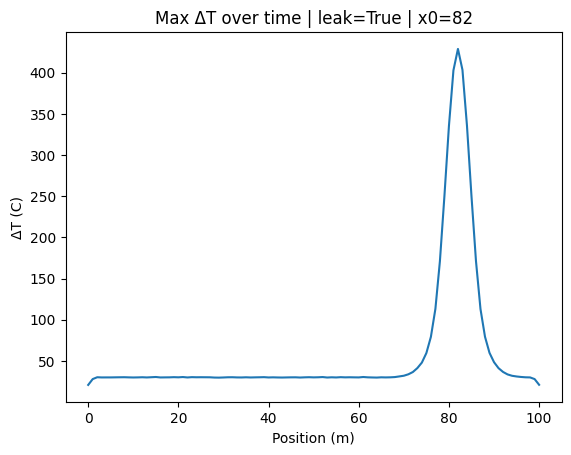

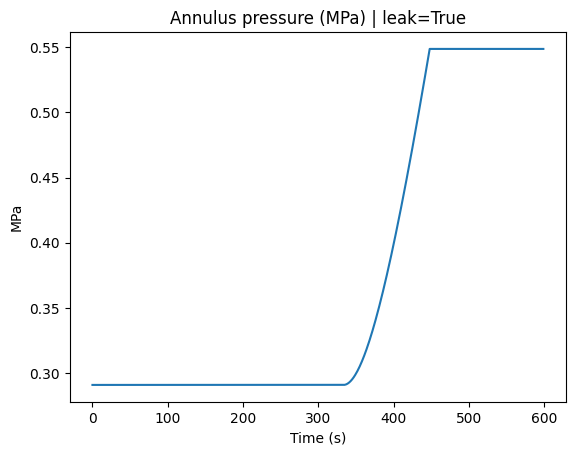

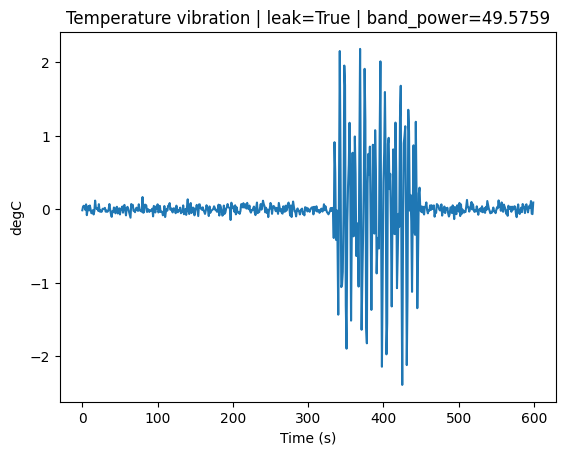

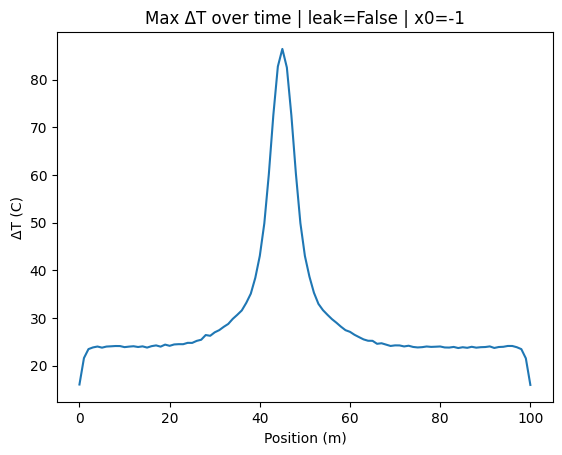

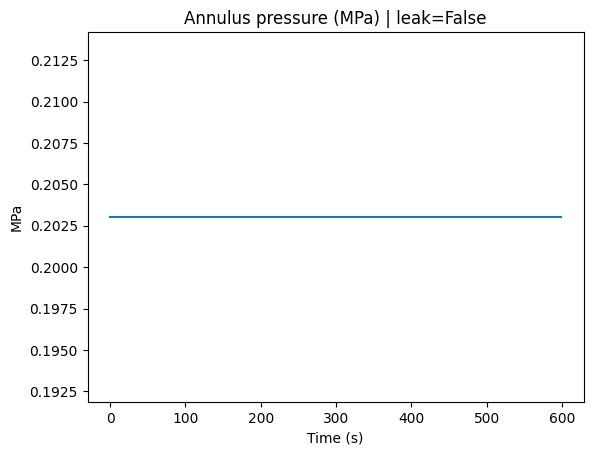

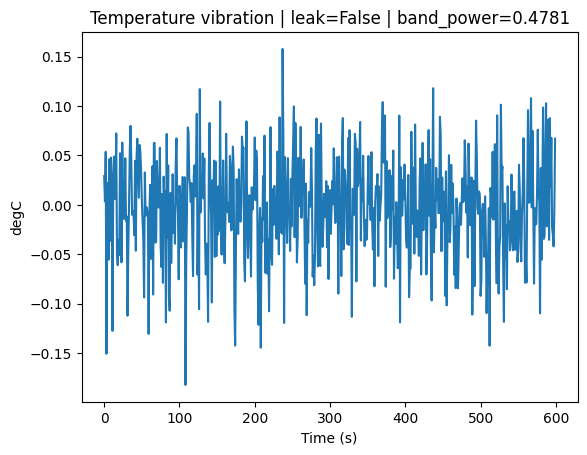

In [12]:
# Cell 11: Optional plots

def plot_one_case_example():
    for leak in [True, False]:
        T_meas, P_ann, temp_vib, y_case, x_case, meta = simulate_case_double_wall_tempvib(leak=leak)
        base = T_meas[:60].mean(axis=0, keepdims=True)
        dT = T_meas - base

        plt.figure()
        plt.plot(X, dT.max(axis=0))
        plt.title(f"Max ΔT over time | leak={leak} | x0={x_case}")
        plt.xlabel("Position (m)"); plt.ylabel("ΔT (C)")
        plt.show()

        plt.figure()
        plt.plot(T, P_ann)
        plt.title(f"Annulus pressure (MPa) | leak={leak}")
        plt.xlabel("Time (s)"); plt.ylabel("MPa")
        plt.show()

        plt.figure()
        plt.plot(T, temp_vib)
        bp = fft_band_power(temp_vib, fs=1.0, f_lo=0.15, f_hi=0.45)
        plt.title(f"Temperature vibration | leak={leak} | band_power={bp:.4f}")
        plt.xlabel("Time (s)"); plt.ylabel("degC")
        plt.show()

plot_one_case_example()

In [13]:
# Cell 12: Final bundle JSON (send this back to me)

RESULT_BUNDLE = {
    "run_info": {
        "seed": SEED,
        "device": DEVICE,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    },
    "constraints_reflected": {
        "T_env_C": T_ENV_C,
        "T_sodium_operating_C": T_NA_IN_C,
        "T_sodium_boiling_C_1atm": T_NA_BOIL_C,
        "inert_gas": ANNULUS_GAS,
        "double_wall_geometry_mm": {
            "Di": Di_m*1e3, "ti": ti_m*1e3, "Do1": Do1_m*1e3,
            "Di2": Di2_m*1e3, "to": to_m*1e3, "Do2": Do2_m*1e3,
            "pinhole_d": PINHOLE_D_m*1e3
        },
        "P_annulus_base_MPa_range": list(P_ANN_BASE_MPA_RANGE),
        "P_sodium_inlet_MPa": P_NA_IN_MPA,
        "m_dot_sodium_per_tube_range_kg_s": list(M_DOT_NA_KG_S_RANGE),
    },
    "data_config": {
        "pipe_len_m": PIPE_LEN_M, "dx_m": DX, "nx": NX,
        "dt_s": DT, "t_total_s": T_TOTAL, "nt": NT,
        "window_s": W_SECONDS, "window_steps": W, "stride_s": STRIDE,
        "n_cases": N_CASES, "leak_ratio": LEAK_RATIO,
        "overlap_thr": OVERLAP_THR,
        "features": [
            "P_ann_mean",
            "P_ann_swing",
            "temp_vib_mean_abs",
            "temp_vib_rms",
            "temp_vib_fft_band_power(0.15-0.45Hz)"
        ],
        "labeling": "Window is leak if overlaps true leak interval (t0,t1) by >= overlap_thr.",
        "location_loss": "Leak-prob-weighted CE using sigmoid(leak_logit).detach().",
    },
    "train_config": {"batch_size": BATCH_SIZE, "epochs": EPOCHS, "lr": 1e-3},
    "history": history,
    "val_loss": float(va),
    "metrics": {"thr_0.4": m04, "thr_0.5": m05, "thr_0.6": m06},
    "diagnostics_sample": {
        "probs_head": probs[:80].tolist(),
        "pred_loc_head": pred_loc[:80].tolist(),
        "true_leak_head": yTL[:80].astype(int).tolist(),
        "true_loc_head": yTLoc[:80].tolist(),
    },
    "notes": [
        "Argon (Ar) used as annulus inert gas.",
        "Pressure/vibration channel replaced by temperature vibration (HF thermal oscillation proxy).",
        "Improvement #1: overlap-based window labeling using true (t0,t1).",
        "Improvement #2: leak-prob-weighted location loss."
    ]
}

RESULT_BUNDLE_JSON = json.dumps(RESULT_BUNDLE, ensure_ascii=False)
print(RESULT_BUNDLE_JSON)

{"run_info": {"seed": 42, "device": "cpu", "timestamp": "2026-02-24 13:55:11"}, "constraints_reflected": {"T_env_C": 700.0, "T_sodium_operating_C": 550.0, "T_sodium_boiling_C_1atm": 883.0, "inert_gas": "Ar", "double_wall_geometry_mm": {"Di": 15.8, "ti": 2.5, "Do1": 20.8, "Di2": 24.8, "to": 2.0, "Do2": 28.8, "pinhole_d": 0.5}, "P_annulus_base_MPa_range": [0.1, 0.3], "P_sodium_inlet_MPa": 1.0, "m_dot_sodium_per_tube_range_kg_s": [0.5, 1.2]}, "data_config": {"pipe_len_m": 100, "dx_m": 1, "nx": 101, "dt_s": 1.0, "t_total_s": 600, "nt": 600, "window_s": 120, "window_steps": 120, "stride_s": 10, "n_cases": 300, "leak_ratio": 0.5, "overlap_thr": 0.2, "features": ["P_ann_mean", "P_ann_swing", "temp_vib_mean_abs", "temp_vib_rms", "temp_vib_fft_band_power(0.15-0.45Hz)"], "labeling": "Window is leak if overlaps true leak interval (t0,t1) by >= overlap_thr.", "location_loss": "Leak-prob-weighted CE using sigmoid(leak_logit).detach()."}, "train_config": {"batch_size": 64, "epochs": 4, "lr": 0.001},

In [14]:
# Cell A1: Baseline preparation
import numpy as np

# Use the same val split arrays you already have:
# Xfeat_tr, Xfeat_va, yL_tr, yL_va, Xtemp_va, yTLoc (or yLoc_va) etc.
# In your notebook: Xfeat_tr, Xfeat_va, yL_tr, yL_va exist.
# Also Xtemp_va exists (temp windows), and yLoc_va exists (true loc or -1).

print("Xfeat_tr:", Xfeat_tr.shape, "Xfeat_va:", Xfeat_va.shape)
print("yL_tr rate:", float(np.mean(yL_tr)), "yL_va rate:", float(np.mean(yL_va)))
print("Xtemp_va:", Xtemp_va.shape, "yLoc_va:", yLoc_va.shape)

Xfeat_tr: (11760, 5) Xfeat_va: (2940, 5)
yL_tr rate: 0.2173469387755102 yL_va rate: 0.2163265306122449
Xtemp_va: (2940, 120, 101) yLoc_va: (2940,)


In [15]:
# Cell A2: Logistic Regression (Leak baseline)
from math import exp

def sigmoid_np(x):
    x = np.clip(x, -50, 50)
    return 1.0/(1.0+np.exp(-x))

def compute_metrics_binary(probs, y_true, thr=0.5):
    y_pred = (probs >= thr).astype(int)
    tp = int(((y_pred==1)&(y_true==1)).sum())
    tn = int(((y_pred==0)&(y_true==0)).sum())
    fp = int(((y_pred==1)&(y_true==0)).sum())
    fn = int(((y_pred==0)&(y_true==1)).sum())
    acc = (tp+tn)/max(tp+tn+fp+fn, 1)
    prec = tp/max(tp+fp, 1)
    rec = tp/max(tp+fn, 1)
    f1 = 2*prec*rec/max(prec+rec, 1e-9)
    return {"thr": float(thr), "confusion":{"tp":tp,"tn":tn,"fp":fp,"fn":fn},
            "accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1)}

def fit_logit_sklearn(Xtr, ytr):
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression

    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    clf = LogisticRegression(max_iter=2000, solver="lbfgs")
    clf.fit(Xtr_s, ytr)

    coef = clf.coef_.reshape(-1)      # shape (p,)
    intercept = float(clf.intercept_[0])
    return clf, scaler, intercept, coef

def fit_logit_numpy(Xtr, ytr, lr=0.1, steps=4000, l2=1e-3):
    # Standardize
    mu = Xtr.mean(axis=0)
    sd = Xtr.std(axis=0) + 1e-8
    X = (Xtr - mu)/sd
    y = ytr.astype(np.float64)

    n, p = X.shape
    w = np.zeros(p, dtype=np.float64)
    b = 0.0

    for _ in range(steps):
        z = X@w + b
        p_hat = sigmoid_np(z)
        # gradients
        gw = (X.T @ (p_hat - y))/n + l2*w
        gb = float(np.mean(p_hat - y))
        w -= lr*gw
        b -= lr*gb

    model = {"mu":mu, "sd":sd, "w":w, "b":b}
    return model

def predict_logit_sklearn(clf, scaler, X):
    return clf.predict_proba(scaler.transform(X))[:,1]

def predict_logit_numpy(model, X):
    Xs = (X - model["mu"])/model["sd"]
    z = Xs@model["w"] + model["b"]
    return sigmoid_np(z)

# Try sklearn first, fallback otherwise
logit_backend = None
try:
    clf, scaler, b0, beta = fit_logit_sklearn(Xfeat_tr, yL_tr)
    p_va = predict_logit_sklearn(clf, scaler, Xfeat_va)
    logit_backend = "sklearn"
except Exception as e:
    print("sklearn logistic regression not available or failed. Falling back to numpy. Error:", e)
    model_np = fit_logit_numpy(Xfeat_tr, yL_tr, lr=0.2, steps=6000, l2=5e-4)
    p_va = predict_logit_numpy(model_np, Xfeat_va)
    logit_backend = "numpy"
    # Convert to standardized-form coefficients for reporting
    # In numpy backend, model_np already standardized: logit(p)=b + sum w_j*(x_j-mu)/sd
    # We'll keep it like that in reporting.
    b0 = float(model_np["b"])
    beta = model_np["w"].copy()

# Evaluate at thr=0.5/0.6 (report-friendly)
logit_m05 = compute_metrics_binary(p_va, yL_va, thr=0.5)
logit_m06 = compute_metrics_binary(p_va, yL_va, thr=0.6)

print("Logistic baseline backend:", logit_backend)
print("Logistic baseline metrics@0.5:", logit_m05)
print("Logistic baseline metrics@0.6:", logit_m06)

Logistic baseline backend: sklearn
Logistic baseline metrics@0.5: {'thr': 0.5, 'confusion': {'tp': 624, 'tn': 2292, 'fp': 12, 'fn': 12}, 'accuracy': 0.9918367346938776, 'precision': 0.9811320754716981, 'recall': 0.9811320754716981, 'f1': 0.9811320754716981}
Logistic baseline metrics@0.6: {'thr': 0.6, 'confusion': {'tp': 621, 'tn': 2294, 'fp': 10, 'fn': 15}, 'accuracy': 0.9914965986394558, 'precision': 0.9841521394611727, 'recall': 0.9764150943396226, 'f1': 0.9802683504340962}


In [16]:
# Cell A3: Print report-ready regression equation (with coefficients)

feature_names = [
    "P_ann_mean",
    "P_ann_swing",
    "temp_vib_mean_abs",
    "temp_vib_rms",
    "temp_vib_fft_band_power(0.15-0.45Hz)"
]

def format_equation(intercept, coef, names, backend, scaler=None):
    lines = []
    lines.append("Leak probability baseline (Logistic Regression)")
    lines.append("p = 1 / (1 + exp(-(b0 + Σ b_j * z_j)))")
    lines.append("where z_j are the standardized features." if backend=="numpy" else "where z_j are standardized using training mean/std.")
    lines.append(f"b0 = {intercept:.6f}")
    for n, c in zip(names, coef):
        lines.append(f"b[{n}] = {float(c):.6f}")
    return "\n".join(lines)

eq_text = format_equation(b0, beta, feature_names, logit_backend, scaler if logit_backend=="sklearn" else None)
print(eq_text)

Leak probability baseline (Logistic Regression)
p = 1 / (1 + exp(-(b0 + Σ b_j * z_j)))
where z_j are standardized using training mean/std.
b0 = -1.229602
b[P_ann_mean] = -0.720865
b[P_ann_swing] = 4.666845
b[temp_vib_mean_abs] = 9.075584
b[temp_vib_rms] = 0.951058
b[temp_vib_fft_band_power(0.15-0.45Hz)] = -2.922939


In [17]:
# Cell A4: Location baseline via temperature-change centroid

def centroid_location_from_window(Xtemp_window):
    """
    Xtemp_window: (W, NX) = ΔT over time & space for a single window
    We compute s(x) = max_t ΔT(t,x), then s_+(x)=max(s,0), then centroid.
    Returns predicted location bin (int).
    """
    s = np.max(Xtemp_window, axis=0)              # (NX,)
    s_pos = np.maximum(s, 0.0)
    denom = float(np.sum(s_pos))
    if denom <= 1e-9:
        # If no positive signal, default to middle (or 0). We'll choose middle.
        return int(len(s_pos)//2)
    x_idx = np.arange(len(s_pos))
    x_hat = float(np.sum(x_idx * s_pos) / denom)
    return int(np.round(x_hat))

# Evaluate centroid baseline MAE on true leak windows (and also on predicted leak windows if you want)
true_leak_mask = (yLoc_va >= 0)  # only windows labeled as leak
centroid_preds = np.array([centroid_location_from_window(Xtemp_va[i]) for i in range(len(Xtemp_va))], dtype=int)

if true_leak_mask.any():
    centroid_mae = float(np.mean(np.abs(centroid_preds[true_leak_mask] - yLoc_va[true_leak_mask])) * DX)
else:
    centroid_mae = None

print("Centroid location baseline MAE on true leak windows (m):", centroid_mae)

Centroid location baseline MAE on true leak windows (m): 14.674528301886792


In [18]:
# Cell A5: Comparison table (CNN vs Logistic vs Centroid)

# CNN metrics from your existing run:
# m05 (CNN @0.5), m06 (CNN @0.6) exist in your notebook.
# If not, define them by running your Cell 10 metrics.

cnn_m05 = m05
cnn_m06 = m06

comparison = {
    "Leak detection @thr=0.5": {
        "CNN": {"precision": cnn_m05["precision"], "recall": cnn_m05["recall"], "f1": cnn_m05["f1"], "fp": cnn_m05["confusion"]["fp"], "fn": cnn_m05["confusion"]["fn"]},
        "Logistic(5 features)": {"precision": logit_m05["precision"], "recall": logit_m05["recall"], "f1": logit_m05["f1"], "fp": logit_m05["confusion"]["fp"], "fn": logit_m05["confusion"]["fn"]},
    },
    "Leak detection @thr=0.6": {
        "CNN": {"precision": cnn_m06["precision"], "recall": cnn_m06["recall"], "f1": cnn_m06["f1"], "fp": cnn_m06["confusion"]["fp"], "fn": cnn_m06["confusion"]["fn"]},
        "Logistic(5 features)": {"precision": logit_m06["precision"], "recall": logit_m06["recall"], "f1": logit_m06["f1"], "fp": logit_m06["confusion"]["fp"], "fn": logit_m06["confusion"]["fn"]},
    },
    "Location MAE (m)": {
        "CNN (predicted leak windows)": cnn_m05["loc_mae_m_predicted_leak"],
        "Centroid (true leak windows)": centroid_mae
    }
}

print(json.dumps(comparison, indent=2, ensure_ascii=False))

{
  "Leak detection @thr=0.5": {
    "CNN": {
      "precision": 0.937592867756315,
      "recall": 0.9921383647798742,
      "f1": 0.9640947288006111,
      "fp": 42,
      "fn": 5
    },
    "Logistic(5 features)": {
      "precision": 0.9811320754716981,
      "recall": 0.9811320754716981,
      "f1": 0.9811320754716981,
      "fp": 12,
      "fn": 12
    }
  },
  "Leak detection @thr=0.6": {
    "CNN": {
      "precision": 0.9515151515151515,
      "recall": 0.9874213836477987,
      "f1": 0.9691358024691358,
      "fp": 32,
      "fn": 8
    },
    "Logistic(5 features)": {
      "precision": 0.9841521394611727,
      "recall": 0.9764150943396226,
      "f1": 0.9802683504340962,
      "fp": 10,
      "fn": 15
    }
  },
  "Location MAE (m)": {
    "CNN (predicted leak windows)": 0.30269413629160064,
    "Centroid (true leak windows)": 14.674528301886792
  }
}


In [19]:
# Cell A6: Extend RESULT_BUNDLE with baselines

BASELINE_BUNDLE = {
    "logistic_backend": logit_backend,
    "logistic_equation": {
        "note": "Coefficients are for standardized features (training mean/std).",
        "b0": float(b0),
        "beta": {name: float(val) for name, val in zip(feature_names, beta)},
        "features": feature_names
    },
    "logistic_metrics": {
        "thr_0.5": logit_m05,
        "thr_0.6": logit_m06
    },
    "centroid_location_baseline": {
        "definition": "x_hat = Σ x*s_+(x) / Σ s_+(x), where s(x)=max_t ΔT(t,x) within a window and s_+=max(s,0).",
        "loc_mae_m_on_true_leak_windows": centroid_mae
    }
}

# If you already have RESULT_BUNDLE from the last cell, merge into it:
try:
    RESULT_BUNDLE["baselines"] = BASELINE_BUNDLE
    RESULT_BUNDLE_JSON = json.dumps(RESULT_BUNDLE, ensure_ascii=False)
    print(RESULT_BUNDLE_JSON)
except NameError:
    # If RESULT_BUNDLE is not defined in this runtime, print baseline json only
    print(json.dumps(BASELINE_BUNDLE, ensure_ascii=False))

{"run_info": {"seed": 42, "device": "cpu", "timestamp": "2026-02-24 13:55:11"}, "constraints_reflected": {"T_env_C": 700.0, "T_sodium_operating_C": 550.0, "T_sodium_boiling_C_1atm": 883.0, "inert_gas": "Ar", "double_wall_geometry_mm": {"Di": 15.8, "ti": 2.5, "Do1": 20.8, "Di2": 24.8, "to": 2.0, "Do2": 28.8, "pinhole_d": 0.5}, "P_annulus_base_MPa_range": [0.1, 0.3], "P_sodium_inlet_MPa": 1.0, "m_dot_sodium_per_tube_range_kg_s": [0.5, 1.2]}, "data_config": {"pipe_len_m": 100, "dx_m": 1, "nx": 101, "dt_s": 1.0, "t_total_s": 600, "nt": 600, "window_s": 120, "window_steps": 120, "stride_s": 10, "n_cases": 300, "leak_ratio": 0.5, "overlap_thr": 0.2, "features": ["P_ann_mean", "P_ann_swing", "temp_vib_mean_abs", "temp_vib_rms", "temp_vib_fft_band_power(0.15-0.45Hz)"], "labeling": "Window is leak if overlaps true leak interval (t0,t1) by >= overlap_thr.", "location_loss": "Leak-prob-weighted CE using sigmoid(leak_logit).detach()."}, "train_config": {"batch_size": 64, "epochs": 4, "lr": 0.001},